In [4]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

# ====== RUTAS (MISMA FECHA) ======
image_directory = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_stack_20251210")

end_dir = image_directory.parent / "endmembers_20251210"
veg_csv = end_dir / "average_veg_values.csv"
soil_csv = end_dir / "average_soil_values.csv"

# Salidas estilo notebook 6
veg_output_directory  = image_directory.parent / "vegetation_abundance_maps_20251210"
soil_output_directory = image_directory.parent / "soil_abundance_maps_20251210"
tif_output_directory  = image_directory.parent / "LUM_outputs_20251210"

veg_output_directory.mkdir(parents=True, exist_ok=True)
soil_output_directory.mkdir(parents=True, exist_ok=True)
tif_output_directory.mkdir(parents=True, exist_ok=True)

band_names = ['B', 'G', 'R', 'RE', 'NIR']

def ensure_reflectance(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32)
    mx = np.nanmax(arr)
    if mx > 1.5:
        arr = arr / 10000.0
    return arr

def parse_plot_id_from_label(label: str) -> int:
    m = re.search(r"plot_(\d+)_stack", str(label))
    return int(m.group(1)) if m else None

# cargar endmembers
veg_df = pd.read_csv(veg_csv)
soil_df = pd.read_csv(soil_csv)

veg_dict, soil_dict = {}, {}
for _, row in veg_df.iterrows():
    pid = parse_plot_id_from_label(row["Bands"])
    veg_dict[pid] = row[band_names].astype(float).values.astype(np.float32)

for _, row in soil_df.iterrows():
    pid = parse_plot_id_from_label(row["Bands"])
    soil_dict[pid] = row[band_names].astype(float).values.astype(np.float32)

print("✅ Endmembers listos:", len(veg_dict), len(soil_dict))
print("Salida PNG veg:", veg_output_directory)
print("Salida PNG soil:", soil_output_directory)
print("Salida TIF:", tif_output_directory)


✅ Endmembers listos: 202 202
Salida PNG veg: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\vegetation_abundance_maps_20251210
Salida PNG soil: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\soil_abundance_maps_20251210
Salida TIF: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\LUM_outputs_20251210


In [5]:
def save_abundance_png(abund_map, out_path, title):
    plt.figure(figsize=(6,5))
    plt.imshow(abund_map, cmap="viridis")
    plt.colorbar(shrink=0.8, label="Abundance")
    plt.title(title)
    plt.axis("off")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

def lum_for_plot(stack5, veg_end, soil_end):
    img = ensure_reflectance(stack5)
    H, W = img.shape[1], img.shape[2]

    valid = np.all(np.isfinite(img), axis=0) & np.all(img > 0, axis=0)
    valid_flat = valid.reshape(-1)

    pixels = img.reshape(5, -1).T  # (N,5)

    E = np.vstack([veg_end, soil_end]).astype(np.float32)  # (2,5)
    pinvE = np.linalg.pinv(E).astype(np.float32)           # (5,2)

    A = np.full((pixels.shape[0], 2), np.nan, dtype=np.float32)
    A[valid_flat] = pixels[valid_flat] @ pinvE
    A = np.clip(A, 0.0, 1.0)

    RL = np.full((pixels.shape[0], 5), np.nan, dtype=np.float32)
    RL[valid_flat] = A[valid_flat] @ E
    RL_img = RL.T.reshape(5, H, W)

    A_veg  = A[:, 0].reshape(H, W)
    A_soil = A[:, 1].reshape(H, W)
    return A_veg, A_soil, RL_img

tifs = sorted(image_directory.glob("plot_*_stack.tif"))
print("Plots encontrados:", len(tifs))

ok, skip, fail = 0, 0, 0

for tif_path in tifs:
    m = re.search(r"plot_(\d+)_stack\.tif$", tif_path.name)
    if not m:
        continue
    plot_id = int(m.group(1))
    plot_name = f"plot_{plot_id}"

    veg_end = veg_dict.get(plot_id)
    soil_end = soil_dict.get(plot_id)

    if veg_end is None or soil_end is None or np.isnan(veg_end).any() or np.isnan(soil_end).any():
        print(f"[SKIP] {plot_name}: endmembers faltan o NaN")
        skip += 1
        continue

    try:
        with rasterio.open(tif_path) as src:
            stack = src.read()
            profile = src.profile.copy()

        A_veg, A_soil, RL = lum_for_plot(stack, veg_end, soil_end)

        # PNGs
        save_abundance_png(A_veg,  veg_output_directory  / f"{plot_name}_vegetation_abundance_map.png",
                           f"{plot_name} - Vegetation Abundance")
        save_abundance_png(A_soil, soil_output_directory / f"{plot_name}_soil_abundance_map.png",
                           f"{plot_name} - Soil Abundance")

        # GeoTIFF abundancias (2 bandas)
        prof_a = profile.copy()
        prof_a.update(count=2, dtype="float32", nodata=None)
        abund_tif = tif_output_directory / f"{plot_name}_LUM_abund.tif"
        with rasterio.open(abund_tif, "w", **prof_a) as dst:
            dst.write(A_veg.astype(np.float32), 1)
            dst.write(A_soil.astype(np.float32), 2)

        # GeoTIFF RL (5 bandas)
        prof_rl = profile.copy()
        prof_rl.update(count=5, dtype="float32", nodata=None)
        rl_tif = tif_output_directory / f"{plot_name}_LUM_RL.tif"
        with rasterio.open(rl_tif, "w", **prof_rl) as dst:
            dst.write(RL.astype(np.float32))

        print(f"[OK] {plot_name} -> {abund_tif.name} + {rl_tif.name}")
        ok += 1

    except Exception as e:
        print(f"[FAIL] {plot_name}: {e}")
        fail += 1

print("\n✅ Terminado Paso 6")
print("OK:", ok, "| SKIP:", skip, "| FAIL:", fail)


Plots encontrados: 202
[OK] plot_100 -> plot_100_LUM_abund.tif + plot_100_LUM_RL.tif
[OK] plot_101 -> plot_101_LUM_abund.tif + plot_101_LUM_RL.tif
[OK] plot_102 -> plot_102_LUM_abund.tif + plot_102_LUM_RL.tif
[OK] plot_103 -> plot_103_LUM_abund.tif + plot_103_LUM_RL.tif
[OK] plot_104 -> plot_104_LUM_abund.tif + plot_104_LUM_RL.tif
[OK] plot_105 -> plot_105_LUM_abund.tif + plot_105_LUM_RL.tif
[OK] plot_106 -> plot_106_LUM_abund.tif + plot_106_LUM_RL.tif
[OK] plot_107 -> plot_107_LUM_abund.tif + plot_107_LUM_RL.tif
[OK] plot_108 -> plot_108_LUM_abund.tif + plot_108_LUM_RL.tif
[OK] plot_109 -> plot_109_LUM_abund.tif + plot_109_LUM_RL.tif
[OK] plot_10 -> plot_10_LUM_abund.tif + plot_10_LUM_RL.tif
[OK] plot_110 -> plot_110_LUM_abund.tif + plot_110_LUM_RL.tif
[OK] plot_111 -> plot_111_LUM_abund.tif + plot_111_LUM_RL.tif
[OK] plot_112 -> plot_112_LUM_abund.tif + plot_112_LUM_RL.tif
[OK] plot_113 -> plot_113_LUM_abund.tif + plot_113_LUM_RL.tif
[OK] plot_114 -> plot_114_LUM_abund.tif + plot_114

Mostrando: plot_100


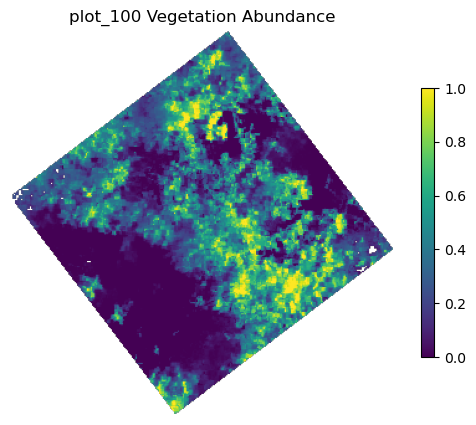

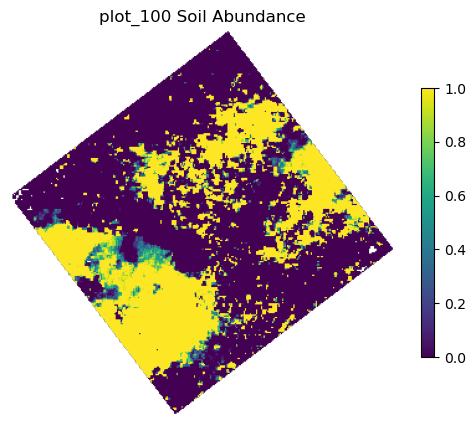

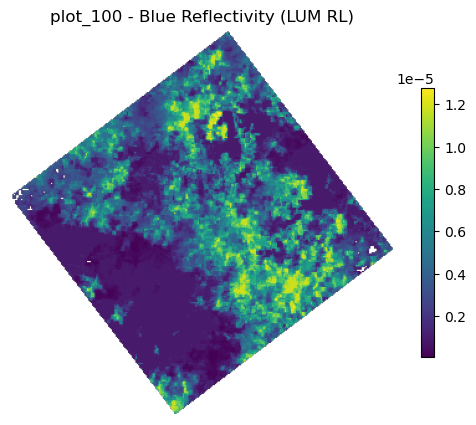

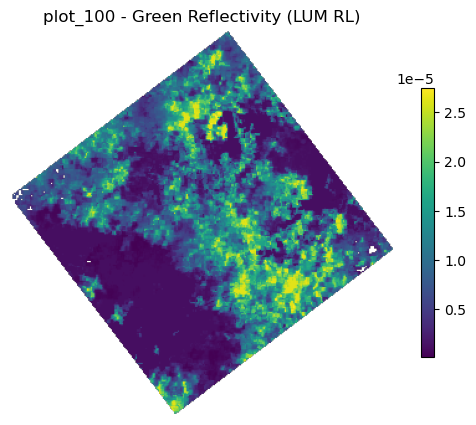

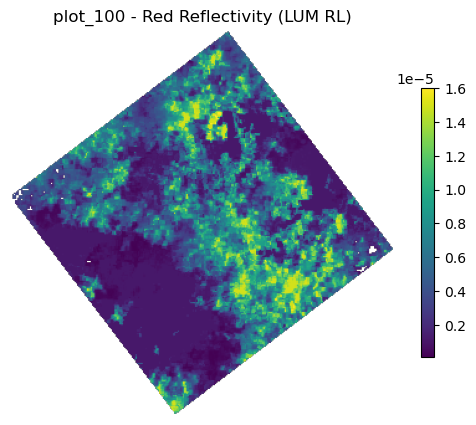

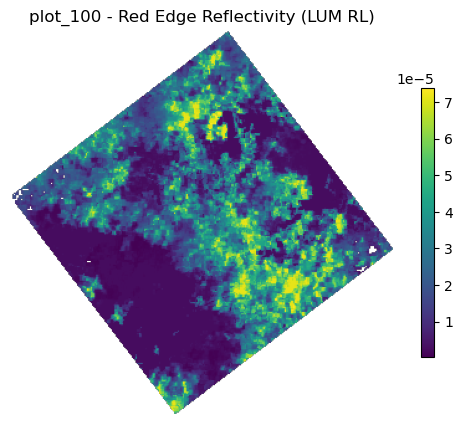

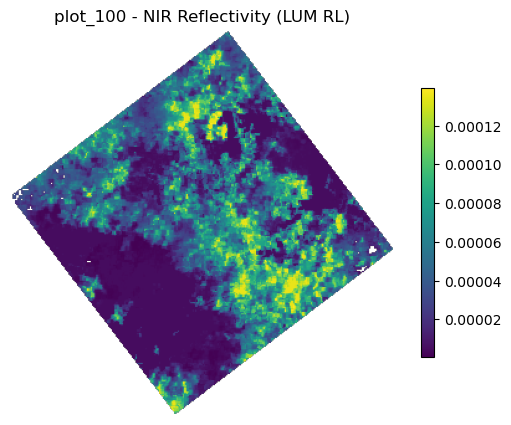

In [6]:
import rasterio
import matplotlib.pyplot as plt
import re

abund_files = sorted(tif_output_directory.glob("plot_*_LUM_abund.tif"))
if len(abund_files) == 0:
    raise FileNotFoundError(f"No hay *_LUM_abund.tif en {tif_output_directory}")

abund_tif = abund_files[0]
m = re.search(r"(plot_\d+)_LUM_abund\.tif$", abund_tif.name)
plot_name = m.group(1) if m else abund_tif.stem.replace("_LUM_abund","")
rl_tif = tif_output_directory / f"{plot_name}_LUM_RL.tif"

print("Mostrando:", plot_name)

with rasterio.open(abund_tif) as src:
    A_veg  = src.read(1)
    A_soil = src.read(2)

plt.figure(figsize=(7,5))
plt.imshow(A_veg, cmap="viridis"); plt.colorbar(shrink=0.7)
plt.title(f"{plot_name} Vegetation Abundance"); plt.axis("off"); plt.show()

plt.figure(figsize=(7,5))
plt.imshow(A_soil, cmap="viridis"); plt.colorbar(shrink=0.7)
plt.title(f"{plot_name} Soil Abundance"); plt.axis("off"); plt.show()

band_titles = ['Blue', 'Green', 'Red', 'Red Edge', 'NIR']
with rasterio.open(rl_tif) as src:
    RL = src.read()

for i, bname in enumerate(band_titles):
    plt.figure(figsize=(7,5))
    plt.imshow(RL[i], cmap="viridis")
    plt.colorbar(shrink=0.7)
    plt.title(f"{plot_name} - {bname} Reflectivity (LUM RL)")
    plt.axis("off")
    plt.show()
